# OPTA XML Parser

[https://fcpython.com/blog/parsing-opta-f24-files-introduction-xml-python](https://fcpython.com/blog/parsing-opta-f24-files-introduction-xml-python)

In [100]:
import csv
import xml.etree.ElementTree as et
import numpy as np
import pandas as pd
from datetime import datetime as dt

# !pip install mplsoccer
from mplsoccer import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import seaborn as sns


In [101]:
tree = et.ElementTree(file="../SampleData/f24-8-2012-441999-eventdetails.xml")
gameFile = tree.getroot()
gameFile[0].attrib

{'id': '441999',
 'away_team_id': '56',
 'away_team_name': 'Sunderland',
 'competition_id': '8',
 'competition_name': 'English Barclays Premier League',
 'game_date': '2012-08-18T15:00:00',
 'home_team_id': '3',
 'home_team_name': 'Arsenal',
 'matchday': '1',
 'period_1_start': '2012-08-18T15:01:59',
 'period_2_start': '2012-08-18T16:04:18',
 'season_id': '2012',
 'season_name': 'Season 2012/2013'}

In [102]:
print(
    "{} vs {}".format(
        gameFile[0].attrib["home_team_name"], gameFile[0].attrib["away_team_name"]
    )
)

Arsenal vs Sunderland


In [103]:
gameFile[0][0].attrib

{'id': '688830980',
 'event_id': '1',
 'type_id': '34',
 'period_id': '16',
 'min': '0',
 'sec': '0',
 'team_id': '3',
 'outcome': '1',
 'x': '0.0',
 'y': '0.0',
 'timestamp': '2012-08-18T14:31:54.810',
 'last_modified': '2012-08-18T14:31:54'}

In [104]:
gameFile[0][0][0].attrib

{'id': '1819768238', 'qualifier_id': '194', 'value': '15943'}

In [105]:
team_dict = {
    gameFile[0].attrib["home_team_id"]: gameFile[0].attrib["home_team_name"],
    gameFile[0].attrib["away_team_id"]: gameFile[0].attrib["away_team_name"],
}


print(team_dict)

{'3': 'Arsenal', '56': 'Sunderland'}


In [106]:
x_origin = []
y_origin = []
x_destination = []
y_destination = []
outcome = []
minute = []
half = []
team = []
player = []
to_player = []
player_positions = {}
to_player_positions = {}

In [107]:
# Iterate through each game in our file - we only have one
for game in gameFile:

    # Iterate through each event
    for event in game:

        # If the event is a pass (ID = 1)
        if event.attrib.get("type_id") == "1":

            # To the correct list, append the correct attribute using attrib.get()
            x_origin.append(event.attrib.get("x"))
            y_origin.append(event.attrib.get("y"))
            outcome.append(event.attrib.get("outcome"))
            minute.append(event.attrib.get("min"))
            half.append(event.attrib.get("period_id"))
            team.append(team_dict[event.attrib.get("team_id")])
            p_id = event.attrib.get("player_id")
            player.append(p_id)

            if p_id not in player_positions:
                player_positions[p_id] = [(event.attrib.get("x"), event.attrib.get("y"))]
            else:
                player_positions[p_id].append((event.attrib.get("x"), event.attrib.get("y")))

            # Iterate through each qualifier
            for qualifier in event:

                # If the qualifier is relevant, append the information to the x or y destination lists
                if qualifier.attrib.get("qualifier_id") == "140":
                    x_destination.append(qualifier.attrib.get("value"))
                    to_player.append(qualifier.attrib.get("player_id"))
                    to_p_id = qualifier.attrib.get("player_id")
                    if to_p_id not in to_player_positions:
                        to_player_positions[to_p_id] = [
                            (qualifier.attrib.get("value"), qualifier.attrib.get("value"))
                        ]
                    else:
                        to_player_positions[to_p_id].append(
                            (qualifier.attrib.get("value"), qualifier.attrib.get("value"))
                        )
                if qualifier.attrib.get("qualifier_id") == "141":
                    y_destination.append(qualifier.attrib.get("value"))
                    to_player.append(qualifier.attrib.get("player_id"))

In [108]:
column_titles = [
    "team",
    "half",
    "min",
    "x_origin",
    "y_origin",
    "x_destination",
    "y_destination",
    "outcome",
    "player",
    # "avg_player_x",
    # "avg_player_y",
]

# Use pd.DataFrame to create our table, assign the data in the order of our columns and give it the column titles above
final_table = pd.DataFrame(
    data=[
        team,
        half,
        minute,
        x_origin,
        y_origin,
        x_destination,
        y_destination,
        outcome,
        player,
    ],
    index=column_titles,
)

# Transpose, or flip, the table. Otherwise, our table will run from left to right, rather than top to bottom
final_table = final_table.T

final_table["avg_player_x"] = final_table["player"].apply(
    lambda x: np.mean([float(i[0]) for i in player_positions[x] if i[0] is not None])
)
final_table["avg_player_y"] = final_table["player"].apply(
    lambda x: np.mean([float(i[1]) for i in player_positions[x] if i[1] is not None])
)

# Show us the top 5 rows of the table
final_table.head()

,team,half,min,x_origin,y_origin,x_destination,y_destination,outcome,player,avg_player_x,avg_player_y
0,Arsenal,1,0,50.0,50.0,53.7,50.3,1,17733,67.795455,54.100000
1,Arsenal,1,0,53.7,50.3,31.7,52.6,1,19524,65.663953,49.022093
2,Arsenal,1,0,30.6,52.5,77.4,4.7,1,15943,41.209302,63.195349
3,Sunderland,1,0,22.5,100.0,40.1,95.2,0,15073,41.986047,86.100000
4,Arsenal,1,0,58.9,3.9,56.7,16.1,1,80254,57.557143,12.573469


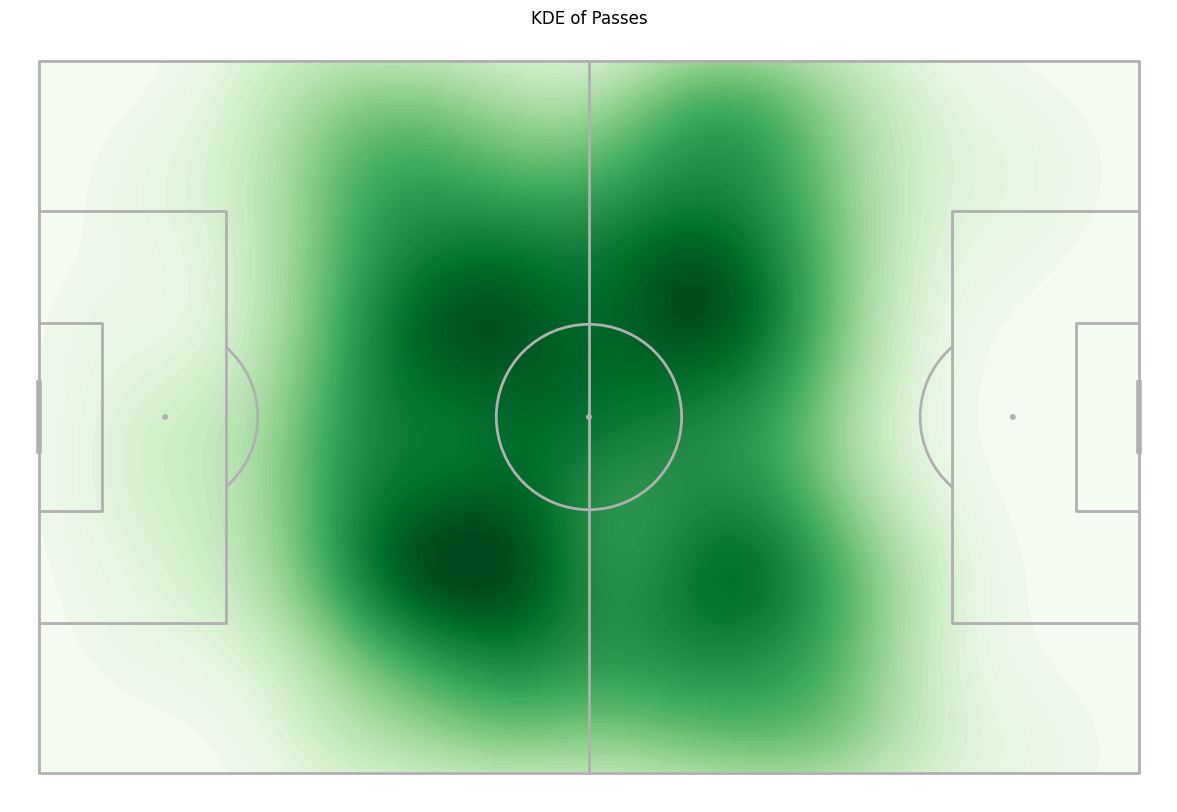

In [109]:
PITCH_WIDTH = 68
PITCH_HEIGHT = 105

pitch = Pitch(
    pitch_type="opta",
    # pitch_width=PITCH_WIDTH,
    # pitch_length=PITCH_HEIGHT,
    line_zorder=2,
    # axis=True, label=True
)

fig, ax = plt.subplots(figsize=(20, 10))
pitch.draw(ax=ax)

completed_passes = final_table[final_table["outcome"] == "1"]

kde = pitch.kdeplot(
    completed_passes.x_origin.astype(float),
    completed_passes.y_origin.astype(float),
    ax=ax,
    cmap="Greens",
    fill=True,
    levels=100,
    thresh=0,
    cut=4,
)

_ = ax.set_title("KDE of Passes")

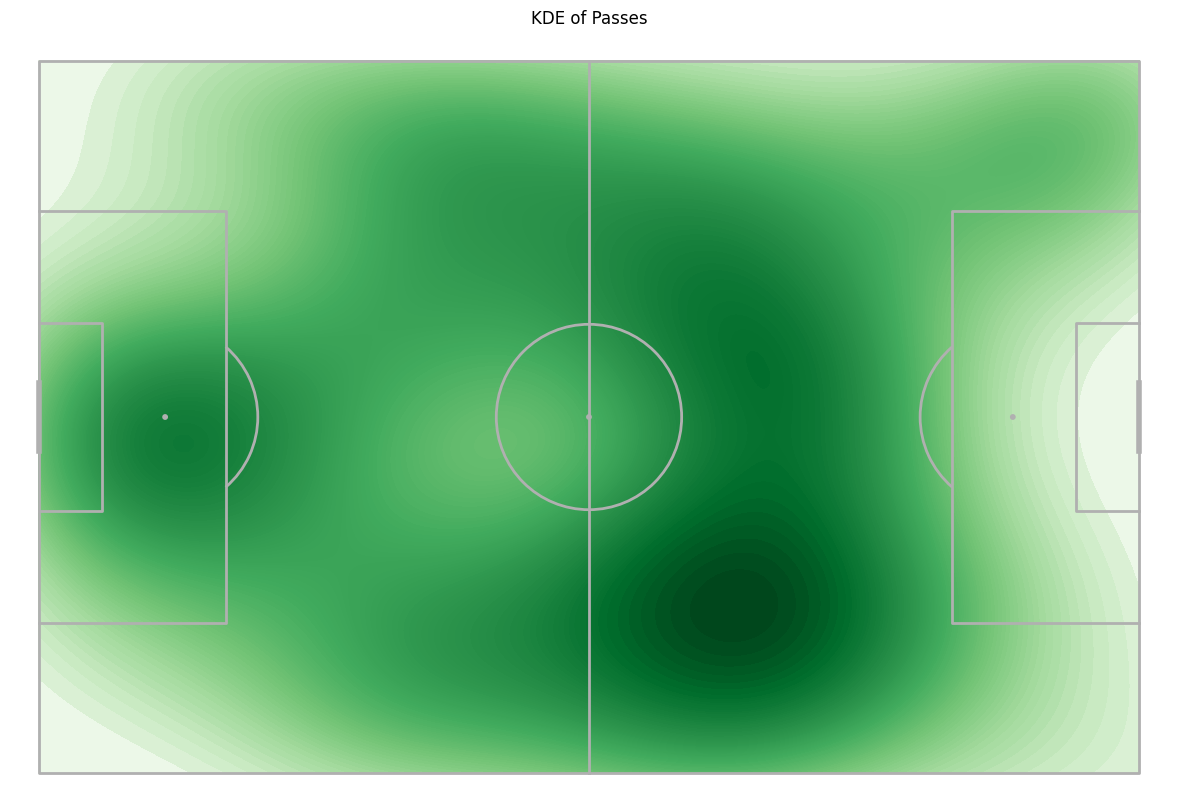

In [110]:
fig, ax = plt.subplots(figsize=(20, 10))
pitch.draw(ax=ax)

missed_passes = final_table[final_table["outcome"] == "0"]

kde = pitch.kdeplot(
    missed_passes.x_origin.astype(float),
    missed_passes.y_origin.astype(float),
    ax=ax,
    cmap="Greens",
    fill=True,
    levels=100,
    thresh=0,
    cut=4,
)

_ = ax.set_title("KDE of Passes")

In [111]:
completed_passes.x_origin.min(), completed_passes.x_origin.max(), completed_passes.y_origin.min(), completed_passes.y_origin.max()

('10.1', '99.5', '0.0', '98.7')

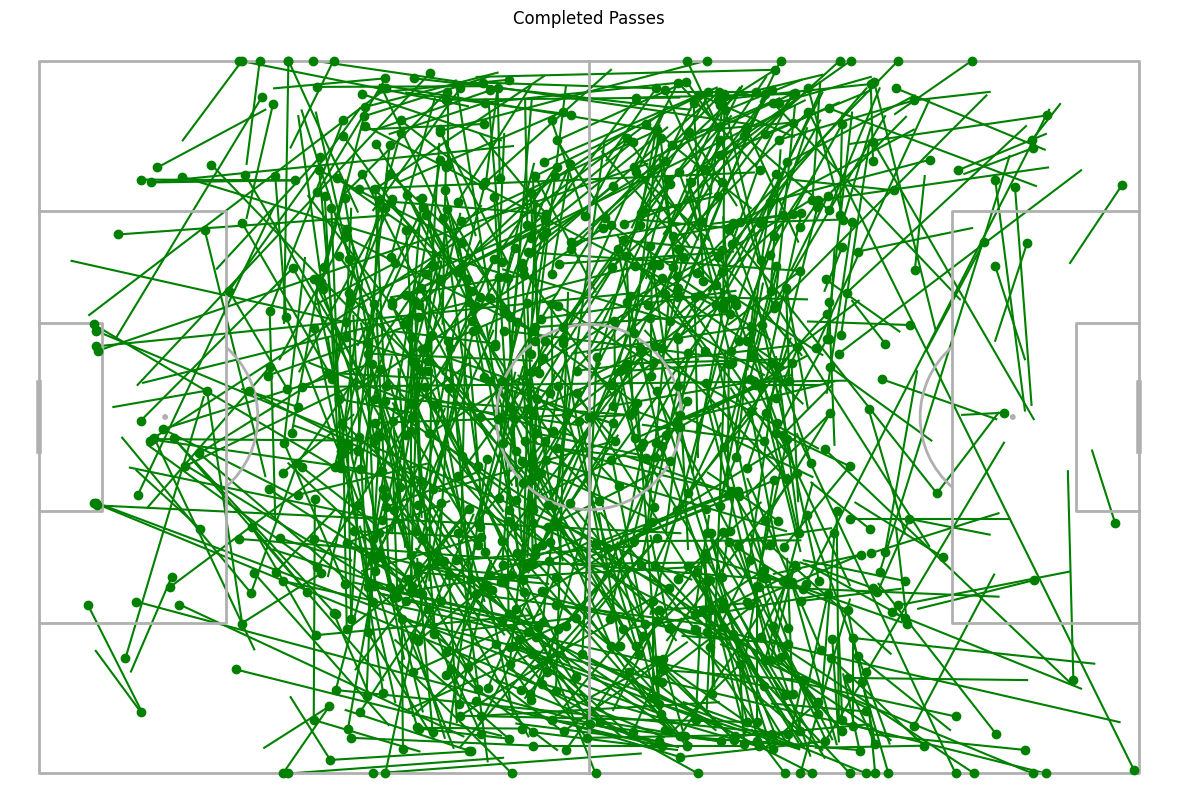

In [112]:
# Completed Passes line plots

fig, ax = plt.subplots(figsize=(20, 10))
pitch.draw(ax=ax)

for i in range(len(completed_passes)):
    ax.plot(
        (
            float(completed_passes.iloc[i].x_origin),
            float(completed_passes.iloc[i].x_destination),
        ),
        (
            float(completed_passes.iloc[i].y_origin),
            float(completed_passes.iloc[i].y_destination),
        ),
        color="green",
        zorder=1,
        # Arrow
    )

    ax.plot(
        float(completed_passes.iloc[i].x_origin),
        float(completed_passes.iloc[i].y_origin),
        "o", 
    color="green")

_ = ax.set_title("Completed Passes")

In [113]:
# Origin pases from avg player position
